# Simulação

In [1]:
import pandas as pd
from sksurv.tree import SurvivalTree
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.datasets import get_x_y
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import brier_score, concordance_index_censored
import plot_survival_tree
from lifelines import KaplanMeierFitter
from itertools import combinations, chain, product
import math
from sklearn.model_selection import cross_val_score

Funções:

In [2]:
transform_int = lambda x: 1 if x == 'Sim' else 0

In [3]:
transform_int_in_english = lambda x: 1 if x == 'Yes' else 0

In [4]:
def transform_in_dummies(df, categorical_cols):
    df_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)
    dummies_cols = df_dummies.columns
    return list(dummies_cols), df_dummies

Lendo os dados:

In [5]:
df = pd.read_csv("/Users/vinicius.oliveira/Downloads/ICESPv1.csv")

Tratamentos iniciais:

In [6]:
df['insuf_cardiaca'] = df['insuf_cardiaca3e4'].apply(lambda x: 1 if x == 'I/II' else 0)

In [7]:
df['tipo_cirurgia'] = df['tipo_cirurgia'].apply(lambda x: 'Nao' if type(x) == float else x)

In [8]:
df['tipo_quimioterapia'] = df['tipo_quimioterapia'].apply(lambda x: 'Nao' if type(x) == float else x)

In [9]:
df['tipo_radioterapia'] = df['tipo_radioterapia'].apply(lambda x: 'Nao' if type(x) == float else x)

In [10]:
meanQV0 = np.mean(df['QV.0'])
df['QV.0'] = df['QV.0'].apply(lambda x: meanQV0 if np.isnan(x) else x)

In [11]:
df['event'] = df['delta'].astype(bool)

Lendo o dataset:

In [12]:
df.head()

,Unnamed: 0,idpac,idade,sexo,imc,imc_cat,insuf_renal,insuf_resp,cirrose,alcoolismo,...,hospit_antes_uti,QV.0,QV.0Cat,SAPS3_Pontos,SAPS3cat,tempo,delta,centro,insuf_cardiaca,event
0,1,001/0001,29.876712,F,16.135394,Underweight,Nao,Nao,Nao,Nao,...,0,0.725,0.6 to 0.8,46,"[38,54)",240,1,ICESP,1,True
1,2,001/0002,26.945205,M,26.122449,Overweight,Nao,Nao,Nao,Nao,...,1,0.088,<0.4,65,"[54,93]",731,0,ICESP,1,False
2,3,001/0003,76.364384,M,27.440599,Overweight,Nao,Nao,Nao,Nao,...,1,0.850,0.8 to 1.0,38,"[38,54)",730,0,ICESP,1,False
3,4,001/0004,71.676712,M,24.382716,Healthy weight,Nao,Nao,Nao,Nao,...,4,0.710,0.6 to 0.8,66,"[54,93]",7,1,ICESP,1,True
4,5,001/0005,25.783562,M,18.113754,Underweight,Nao,Nao,Nao,Nao,...,3,-0.181,<0.4,44,"[38,54)",201,1,ICESP,1,True


Definindo alguns conjuntos de covariáveis:

In [13]:
lstSimNao = ['insuf_renal', 
             'insuf_resp', 
             'cirrose', 
             'alcoolismo'
             #'cirurgia',
             #'quimioterapia',
             #'radioterapia'
            ]

lstYesNo = ['diabetesSN',
            'deliriumSN']

lstCategorical = ['sexo',
                  'tipoadm',
                  'site_primario',
                  'status_cancer',
                  'extensao_cancer',
                  'tipo_cirurgia',
                  'tipo_quimioterapia',
                  'tipo_radioterapia']

lstNum = ['insuf_cardiaca',
          'idade', 
          'imc',
          'QV.0',
          'SAPS3_Pontos',
          'capac_func_ecog',
          'hospit_antes_uti']

In [14]:
for col in lstSimNao:
    
    df[col] = df[col].apply(transform_int)

In [15]:
for col in lstYesNo:
    
    df[col] = df[col].apply(transform_int_in_english)

In [16]:
lstDummies, df_dummies = transform_in_dummies(df, lstCategorical)

In [17]:
df[lstDummies] = df_dummies

In [18]:
df_dummies.describe()

,sexo_M,tipoadm_Emergency,tipoadm_Medical,site_primario_breast,site_primario_digestive tract,site_primario_genital system,site_primario_hematological,site_primario_oral cavity and pharynx,site_primario_other/undeterm,site_primario_respiratory system,...,status_cancer_Controlado_remissao,extensao_cancer_Limitado,extensao_cancer_Localmente avancado,extensao_cancer_Metastase a distancia,tipo_cirurgia_Nao,tipo_cirurgia_Paliativa,tipo_quimioterapia_Nao,tipo_quimioterapia_Paliativa,tipo_radioterapia_Nao,tipo_radioterapia_Paliativa
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,...,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,0.577554,0.050441,0.442623,0.063052,0.350567,0.123581,0.081967,0.071879,0.090794,0.069357,...,0.061791,0.325347,0.358134,0.298865,0.393443,0.071879,0.619168,0.108449,0.784363,0.031526
std,0.494261,0.218992,0.497010,0.243209,0.477449,0.329311,0.274488,0.258450,0.287498,0.254220,...,0.240927,0.468800,0.479754,0.458049,0.488822,0.258450,0.485898,0.311143,0.411523,0.174844
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
lstFeatures = lstDummies + lstNum + lstSimNao + lstYesNo

In [20]:
len(lstFeatures)

35

In [21]:
lstTarget = ['event', 'tempo']

In [22]:
X = df[lstFeatures]
y = df[lstTarget].to_records(index=False)

Proporção de censura:

In [23]:
df['tempo'].describe()

count    793.000000
mean     334.755359
std      316.023339
min        0.000000
25%       22.000000
50%      200.000000
75%      721.000000
max      783.000000
Name: tempo, dtype: float64

In [24]:
1 - y['event'].mean()

0.3404791929382094

Re-amostragem:

In [25]:
#### Então marcar os eventos como censurados. Não precisa fazer réplicas. 
def resample(df, lstFeatures, lstTarget, threshold):
    new_df = df.copy(deep=True)
    n = new_df.shape[0]
    seed = 1234
    rs = np.random.RandomState(seed=seed)
    proportions = rs.uniform(size=n)
    new_df['event'] = np.where(new_df['event'], threshold > proportions, new_df['event'])
    new_df['tempo'] = np.where(new_df['event']==False, 725.5, 
                               new_df['tempo'])
    n = new_df.shape[0]
    new_df = new_df.sample(n=n, random_state=seed, replace=False)
    return new_df

In [26]:
proportions = [0.15, 0.3, 0.45, 0.6, 0.75]

In [27]:
lst_samples = list(map(lambda p: resample(df, lstFeatures, lstTarget, p), proportions))

In [28]:
lst_samples.append(df)

In [29]:
lst_prop_censor = []

In [30]:
for df in lst_samples:
    censor = 1-np.round(df['event'].mean(),2)
    lst_prop_censor.append(censor)

In [31]:
def simulate_model(df, lstFeatures, lstTarget, model, dict_hyperparams):
    X = df[lstFeatures]
    y = df[lstTarget].to_records(index=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    instance = model(**dict_hyperparams)
    instance.fit(X_train,  y_train)
    train_score = instance.score(X_train, y_train)
    test_score = instance.score(X_test, y_test)
    return train_score, test_score

In [44]:
rsf_hyperparms = {'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 50}

In [45]:
lst_rsf_scores = []

In [46]:
for df in lst_samples: 
    rsf_scores = simulate_model(df, 
                             lstFeatures, 
                             lstTarget, 
                             RandomSurvivalForest,
                             rsf_hyperparms)
    lst_rsf_scores.append(rsf_scores)

In [47]:
gbs_hyperparams = {"max_depth":2,
                   "min_samples_leaf":5,
                   "n_estimators":100,
                   "loss": "coxph"}

In [48]:
lst_gbs_scores = []

In [49]:
for df in lst_samples: 
    gbs_scores = simulate_model(df, 
                             lstFeatures, 
                             lstTarget, 
                             GradientBoostingSurvivalAnalysis,
                             gbs_hyperparams)
    lst_gbs_scores.append(gbs_scores)

In [50]:
st_hyperparams = {"max_depth": 6,
                  "min_samples_leaf": 30}

In [51]:
lst_st_scores = []

In [52]:
for df in lst_samples: 
    st_scores = simulate_model(df, 
                             lstFeatures, 
                             lstTarget, 
                             SurvivalTree,
                             st_hyperparams)
    lst_st_scores.append(st_scores)

(0.5, 1.0)

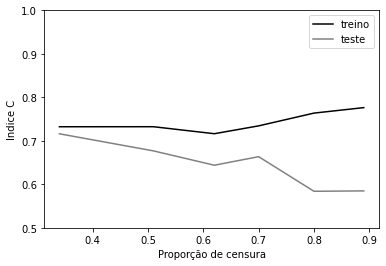

In [53]:
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[0], lst_st_scores)), color='black')
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[1], lst_st_scores)), color='gray')
plt.xlabel("Proporção de censura")
plt.ylabel("Indice C")
plt.legend(['treino', 'teste'])
plt.ylim(0.5, 1.)

(0.5, 1.0)

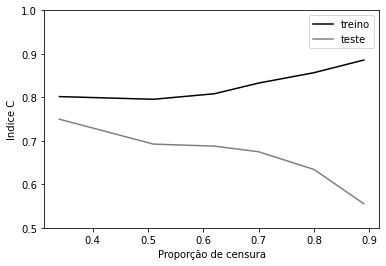

In [54]:
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[0], lst_rsf_scores)), color='black')
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[1], lst_rsf_scores)), color='gray')
plt.xlabel("Proporção de censura")
plt.ylabel("Indice C")
plt.legend(['treino', 'teste'])
plt.ylim(0.5, 1.)

(0.5, 1.0)

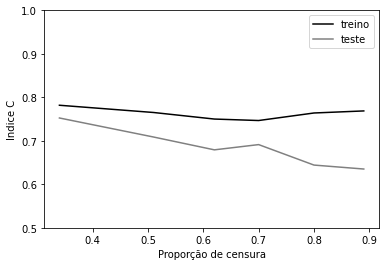

In [55]:
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[0], lst_gbs_scores)), color='black')
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[1], lst_gbs_scores)), color='gray')
plt.xlabel("Proporção de censura")
plt.ylabel("Indice C")
plt.legend(['treino', 'teste'])
plt.ylim(0.5, 1.)

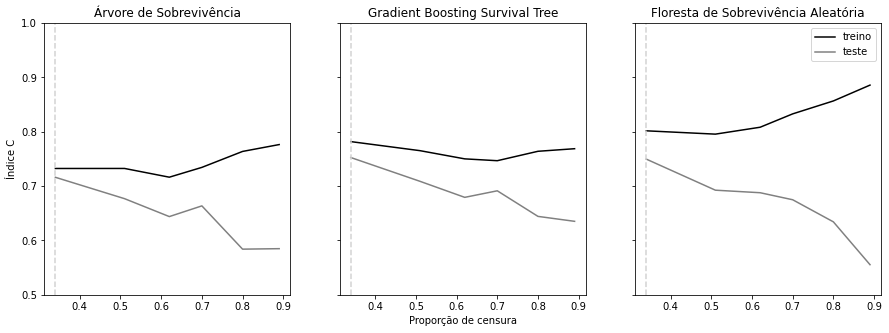

In [62]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[0], lst_st_scores)), color='black', ax=axes[0])
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[1], lst_st_scores)), color='gray', ax=axes[0])
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[0], lst_gbs_scores)), color='black', ax=axes[1])
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[1], lst_gbs_scores)), color='gray', ax=axes[1])
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[0], lst_rsf_scores)), color='black', ax=axes[2])
sns.lineplot(x=lst_prop_censor, y=list(map(lambda x: x[1], lst_rsf_scores)), color='gray', ax=axes[2])
axes[0].set_title("Árvore de Sobrevivência")
axes[1].set_title("Gradient Boosting Survival Tree")
axes[2].set_title("Floresta de Sobrevivência Aleatória")
axes[0].set_ylabel("Índice C")
axes[1].set_xlabel("Proporção de censura")
axes[0].set_ylim(0.5, 1)
axes[0].axvline(0.34, linestyle="dashed", color="lightgray")
axes[1].axvline(0.34, linestyle="dashed", color="lightgray")
axes[2].axvline(0.34, linestyle="dashed", color="lightgray")
plt.legend(['treino','teste'])